In [1]:
import sys
sys.path.append('../../../')

In [2]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error

c:\Users\vibal\miniconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def pretty(ld, indent=0):
    return None
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [4]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_mcc'
metric_filter_2 = 'test_mcc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [5]:
sets_lengths = (0.32, 0.08, 0.6)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = dataset.num_classes

In [6]:
(dataset[0].ndata['train_mask']).sum()

tensor(480)

In [7]:
(dataset[0].ndata['val_mask']).sum()

tensor(120)

In [8]:
(dataset[0].ndata['test_mask']).sum()

tensor(900)

## Baseline

In [9]:
dict_small_acc_train = {}
dict_small_acc_val = {}
dict_small_acc_test = {}
dict_small_rmse_train = {}
dict_small_rmse_val = {}
dict_small_rmse_test = {}
dict_small_mcc_train = {}
dict_small_mcc_val = {}
dict_small_mcc_test = {}

In [10]:
# x_train,x_test,y_train,y_test = train_test_split(dataset.node_features[0].to_numpy(), dataset.targets[0], test_size=0.25, random_state=seed)
g_data = dataset.graphs[0].ndata
feats = g_data['feat']
labels = g_data['label']
train_mask = g_data['train_mask']
val_mask = g_data['val_mask']
test_mask = g_data['test_mask']

# train + val for training, test for test
x_train,x_test = feats[torch.logical_not(test_mask)], feats[test_mask]
y_train,y_test = labels[torch.logical_not(test_mask)], labels[test_mask]

In [11]:
x_train.shape

torch.Size([600, 4])

In [12]:
x_test.shape

torch.Size([900, 4])

### Logistic Regression

In [13]:
model_lr = LogisticRegression(multi_class='multinomial',random_state=seed, max_iter=800).fit(x_train, y_train)
print(classification_report(y_true=y_test, y_pred=model_lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.79      0.65      0.72       220
           1       0.23      0.03      0.06       230
           2       0.34      0.50      0.41       231
           3       0.48      0.77      0.59       219

    accuracy                           0.48       900
   macro avg       0.46      0.49      0.44       900
weighted avg       0.46      0.48      0.44       900



In [14]:
dict_small_acc_train['logistic_regression'] = model_lr.score(x_train, y_train)
dict_small_acc_test['logistic_regression'] = model_lr.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['logistic_regression']}")
print(f"Test accuracy: {dict_small_acc_test['logistic_regression']}")

dict_small_rmse_train['logistic_regression'] = mean_squared_error(y_true=y_train,y_pred=model_lr.predict(x_train), squared=False)
dict_small_rmse_test['logistic_regression'] = mean_squared_error(y_true=y_test,y_pred=model_lr.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['logistic_regression']}")
print(f"Test rmse: {dict_small_rmse_test['logistic_regression']}")

dict_small_mcc_train['logistic_regression'] = matthews_corrcoef(y_true=y_train,y_pred=model_lr.predict(x_train))
dict_small_mcc_test['logistic_regression'] = matthews_corrcoef(y_true=y_test,y_pred=model_lr.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['logistic_regression']}")
print(f"Test mcc: {dict_small_mcc_test['logistic_regression']}")

Train accuracy: 0.485
Test accuracy: 0.48333333333333334
Train rmse: 0.972967967955095
Test rmse: 1.0077477638553982
Train mcc: 0.3277042185594028
Test mcc: 0.33072560030809933


### Random Forest

In [15]:
# # x_train_rf,x_val_rf,y_train_rf,y_val_rf = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)
# x_train_rf,x_val_rf,x_test_rf = feats[train_mask], feats[val_mask], feats[test_mask]
# y_train_rf,y_val_rf,y_test_rf = labels[train_mask], labels[val_mask], labels[test_mask]
x_train_rf = x_train
y_train_rf = y_train
x_val_rf = x_test
y_val_rf = y_test

In [16]:
n = 20
num_nodes = x_train_rf.shape[0]
model_rf = None
val_acc = 0.0
for k in trange(1,num_nodes, (num_nodes - 1) // n):
    tmp = RandomForestClassifier(random_state=seed, n_estimators=k).fit(x_train_rf,y_train_rf)
    tmp_acc = matthews_corrcoef(y_true=y_val_rf,y_pred=tmp.predict(x_val_rf))
    if val_acc < tmp_acc:
        val_acc = tmp_acc
        model_rf = tmp

print(classification_report(y_true=y_test, y_pred=model_rf.predict(x_test)))

100%|██████████| 21/21 [00:10<00:00,  2.00it/s]

              precision    recall  f1-score   support

           0       0.68      0.72      0.70       220
           1       0.33      0.31      0.32       230
           2       0.38      0.34      0.36       231
           3       0.54      0.61      0.57       219

    accuracy                           0.49       900
   macro avg       0.48      0.49      0.49       900
weighted avg       0.48      0.49      0.48       900



In [17]:
model_rf

RandomForestClassifier(n_estimators=30, random_state=4444)

In [18]:
dict_small_acc_train['random_forest'] = model_rf.score(x_train_rf, y_train_rf)
dict_small_acc_val['random_forest'] = model_rf.score(x_val_rf, y_val_rf)
dict_small_acc_test['random_forest'] = model_rf.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['random_forest']}")
print(f"Val accuracy: {dict_small_acc_val['random_forest']}")
print(f"Test accuracy: {dict_small_acc_test['random_forest']}")

dict_small_rmse_train['random_forest'] = mean_squared_error(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf), squared=False)
dict_small_rmse_val['random_forest'] = mean_squared_error(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf), squared=False)
dict_small_rmse_test['random_forest'] = mean_squared_error(y_true=y_test,y_pred=model_rf.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['random_forest']}")
print(f"Val rmse: {dict_small_rmse_val['random_forest']}")
print(f"Test rmse: {dict_small_rmse_test['random_forest']}")

dict_small_mcc_train['random_forest'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf))
dict_small_mcc_val['random_forest'] = matthews_corrcoef(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf))
dict_small_mcc_test['random_forest'] = matthews_corrcoef(y_true=y_test,y_pred=model_rf.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['random_forest']}")
print(f"Val mcc: {dict_small_mcc_val['random_forest']}")
print(f"Test mcc: {dict_small_mcc_test['random_forest']}")

Train accuracy: 0.9983333333333333
Val accuracy: 0.49
Test accuracy: 0.49
Train rmse: 0.040824829046386304
Val rmse: 1.0236101688522725
Test rmse: 1.0236101688522725
Train mcc: 0.9977803889459878
Val mcc: 0.3209613412338584
Test mcc: 0.3209613412338584


In [19]:
from models.utils import load_pickle, ClassConfusionMatrix, save_pickle
cm = ClassConfusionMatrix(dataset.num_classes, name='test')
cm.add(torch.as_tensor(model_rf.predict(x_test)), torch.as_tensor(y_test), torch.zeros(y_test.shape[0]))
save_pickle(cm, '../../results/sym_rf_40.pkl')

### KNN Classifier

In [19]:
model_knn = KNeighborsClassifier(n_neighbors=out_feats).fit(x_train,y_train)
print(classification_report(y_true=y_test, y_pred=model_knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.58      0.72      0.65       220
           1       0.28      0.26      0.27       230
           2       0.30      0.29      0.30       231
           3       0.37      0.32      0.34       219

    accuracy                           0.40       900
   macro avg       0.38      0.40      0.39       900
weighted avg       0.38      0.40      0.39       900



In [20]:
dict_small_acc_train['knn_classifier'] = model_knn.score(x_train_rf, y_train_rf)
dict_small_acc_test['knn_classifier'] = model_knn.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['knn_classifier']}")
print(f"Test accuracy: {dict_small_acc_test['knn_classifier']}")

dict_small_rmse_train['knn_classifier'] = mean_squared_error(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf), squared=False)
dict_small_rmse_test['knn_classifier'] = mean_squared_error(y_true=y_test,y_pred=model_knn.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['knn_classifier']}")
print(f"Test rmse: {dict_small_rmse_test['knn_classifier']}")

dict_small_mcc_train['knn_classifier'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf))
dict_small_mcc_test['knn_classifier'] = matthews_corrcoef(y_true=y_test,y_pred=model_knn.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['knn_classifier']}")
print(f"Test mcc: {dict_small_mcc_test['knn_classifier']}")

Train accuracy: 0.62
Test accuracy: 0.39666666666666667
Train rmse: 0.968676072448026
Test rmse: 1.2233832869001713
Train mcc: 0.49499071589863874
Test mcc: 0.19628592514030305


### FNN

In [21]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [22]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=False,
        )

100%|██████████| 60/60 [04:19<00:00,  4.32s/it]


#### Results

In [23]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 993/993 [00:40<00:00, 24.25it/s]


In [24]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.33940259327622363,
 'epoch': 20,
 'train_loss': 1.235392,
 'train_acc': 0.5104166865348816,
 'val_acc': 0.4999999701976776,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.50_2023-03-29_00.24.39.375241',
 'train_rmse': 0.9264628073124864,
 'val_rmse': 0.9219544457292888,
 'test_rmse': 0.9043106644167025,
 'train_mae': 0.6125,
 'val_mae': 0.6166666666666667,
 'test_mae': 0.5888888888888889,
 'train_mcc': 0.3601494894387913,
 'test_mcc': 0.37512670196821596,
 'test_acc': 0.5233333110809326,
 'train_rmse_perc': 0.22530071,
 'val_rmse_perc': 0.23050307,
 'test_rmse_perc': 0.22442147,
 'train_mae_perc': 0.1

In [25]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.43072999228936315,
 'epoch': 57,
 'train_loss': 1.1814533,
 'train_acc': 0.5270833373069763,
 'val_acc': 0.5583332777023315,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.56_2023-03-29_00.24.39.375241',
 'train_rmse': 1.0185774393731681,
 'val_rmse': 0.9036961141150639,
 'test_rmse': 1.0842303978193728,
 'train_mae': 0.6458333333333334,
 'val_mae': 0.5666666666666667,
 'test_mae': 0.7333333333333333,
 'train_mcc': 0.37953417187791866,
 'test_mcc': 0.32020154091283903,
 'test_acc': 0.47555556893348694,
 'train_rmse_perc': 0.24851644,
 'val_rmse_perc': 0.2244586,
 'test_rmse_perc': 0.26536873,
 'train_

In [26]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.33940259327622363,
 'epoch': 20,
 'train_loss': 1.235392,
 'train_acc': 0.5104166865348816,
 'val_acc': 0.4999999701976776,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.50_2023-03-29_00.24.39.375241_20',
 'train_rmse': 0.9264628073124864,
 'val_rmse': 0.9219544457292888,
 'test_rmse': 0.9043106644167025,
 'train_mae': 0.6125,
 'val_mae': 0.6166666666666667,
 'test_mae': 0.5888888888888889,
 'train_mcc': 0.3601494894387913,
 'test_mcc': 0.37512670196821596,
 'test_acc': 0.5233333110809326,
 'train_rmse_perc': 0.22530071,
 'val_rmse_perc': 0.23050307,
 'test_rmse_perc': 0.22442147,
 'train_mae_perc': 

In [27]:
pretty([all[k]['dict'] for k in sort_idx])

In [28]:
cm = all[sort_idx[0]]['test_cm'][0]

In [29]:
(cm.labels==0).sum()

tensor(220)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

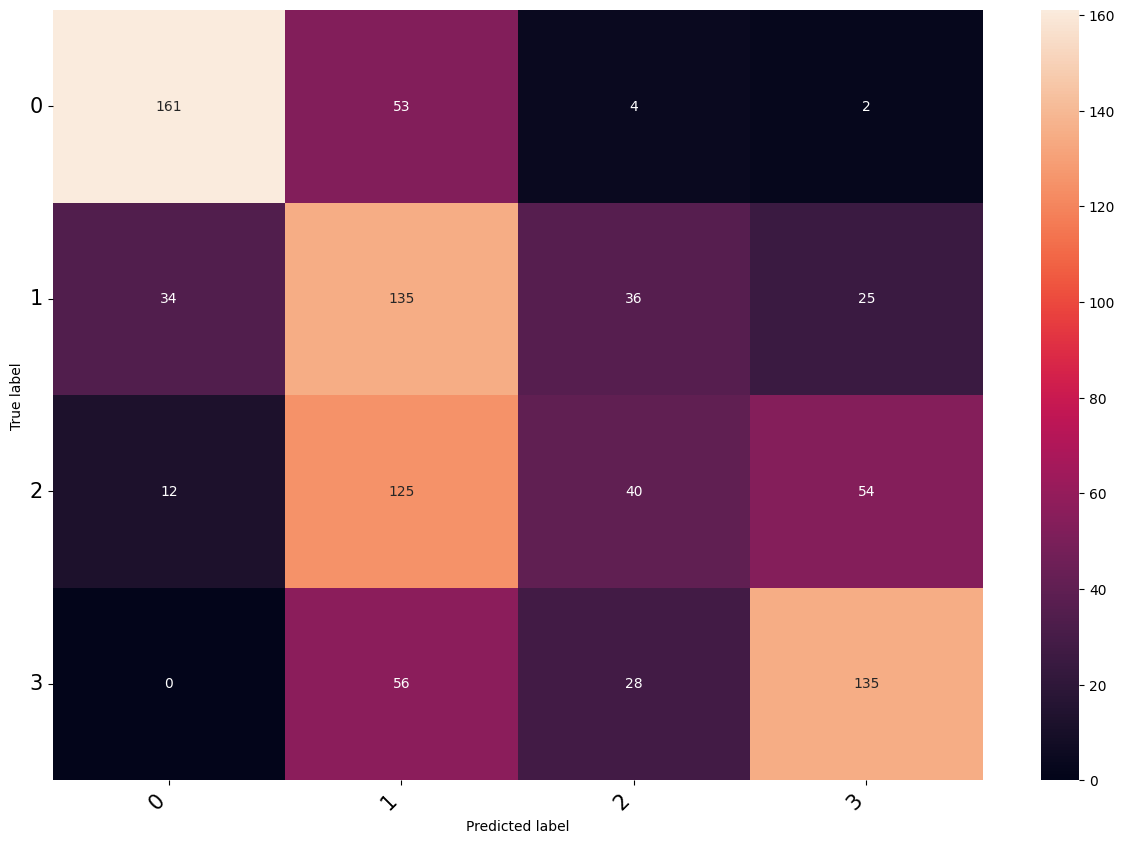

In [30]:
cm.visualize()

In [31]:
cm.class_accuracy

tensor([0.7318, 0.5870, 0.1732, 0.6164])

### Baseline Overall

In [32]:
print(dict_small_acc_train)
print(dict_small_acc_val)
print(dict_small_acc_test)

{'logistic_regression': 0.485, 'random_forest': 0.9983333333333333, 'knn_classifier': 0.62}
{'random_forest': 0.49}
{'logistic_regression': 0.48333333333333334, 'random_forest': 0.49, 'knn_classifier': 0.39666666666666667}


In [33]:
print(dict_small_mcc_train)
print(dict_small_mcc_val)
print(dict_small_mcc_test)

{'logistic_regression': 0.327749651542914, 'random_forest': 0.9977803889459878, 'knn_classifier': 0.49499071589863874}
{'random_forest': 0.3209613412338584}
{'logistic_regression': 0.33069737451215436, 'random_forest': 0.3209613412338584, 'knn_classifier': 0.19628592514030305}


In [34]:
print(dict_small_rmse_train)
print(dict_small_rmse_val)
print(dict_small_rmse_test)

{'logistic_regression': 0.9703951085339758, 'random_forest': 0.040824829046386304, 'knn_classifier': 0.968676072448026}
{'random_forest': 1.0236101688522725}
{'logistic_regression': 1.0060925515191046, 'random_forest': 1.0236101688522725, 'knn_classifier': 1.2233832869001713}


### GCN

In [35]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 5, [15] * 4, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     # h_features=[[5, 10], [10, 15], [5], [10], [15], [10,15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0, 0.2, 0.4],
#     use_edge_weight=[True, False],
#     drop_edges=[0,0.2,0.4],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [36]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 192/192 [27:26<00:00,  8.58s/it]


#### Results

In [37]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 3091/3091 [03:46<00:00, 13.63it/s]


In [38]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5481757796261756,
 'epoch': 37,
 'train_loss': 0.81406224,
 'train_acc': 0.6916666626930237,
 'val_acc': 0.6583333015441895,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.66_2023-03-29_00.42.28.084512',
 'train_rmse': 0.6487166818676188,
 'val_rmse': 0.6645800679125629,
 'test_rmse': 0.6928203230275509,
 'train_mae': 0.3458333333333333,
 'val_mae': 0.375,
 'test_mae': 0.38666666666666666,
 'train_mcc': 0.5900374324468509,
 'test_mcc': 0.5412996006148609,
 'test_acc': 0.6555555462837219,
 'train_rmse_perc': 0.16011064,
 'val_rmse_perc': 0.16735193,
 'test_rmse_perc': 0.1704683,
 

In [39]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5481757796261756,
 'epoch': 37,
 'train_loss': 0.81406224,
 'train_acc': 0.6916666626930237,
 'val_acc': 0.6583333015441895,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.66_2023-03-29_00.42.28.084512',
 'train_rmse': 0.6487166818676188,
 'val_rmse': 0.6645800679125629,
 'test_rmse': 0.6928203230275509,
 'train_mae': 0.3458333333333333,
 'val_mae': 0.375,
 'test_mae': 0.38666666666666666,
 'train_mcc': 0.5900374324468509,
 'test_mcc': 0.5412996006148609,
 'test_acc': 0.6555555462837219,
 'train_rmse_perc': 0.16011064,
 'val_rmse_perc': 0.16735193,
 'test_rmse_perc': 0.1704683,
 

In [40]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5481757796261756,
 'epoch': 37,
 'train_loss': 0.81406224,
 'train_acc': 0.6916666626930237,
 'val_acc': 0.6583333015441895,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.66_2023-03-29_00.42.28.084512',
 'train_rmse': 0.6487166818676188,
 'val_rmse': 0.6645800679125629,
 'test_rmse': 0.6928203230275509,
 'train_mae': 0.3458333333333333,
 'val_mae': 0.375,
 'test_mae': 0.38666666666666666,
 'train_mcc': 0.5900374324468509,
 'test_mcc': 0.5412996006148609,
 'test_acc': 0.6555555462837219,
 'train_rmse_perc': 0.16011064,
 'val_rmse_perc': 0.16735193,
 'test_rmse_perc': 0.1704683,
 

In [41]:
pretty([all[k]['dict'] for k in sort_idx])

### GraphSAGE

In [42]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    # aggregator_type = ['mean', 'lstm'],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[25] * 3, [20] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [43]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 288/288 [3:53:40<00:00, 48.68s/it]  


#### Results

In [44]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 6924/6924 [27:48<00:00,  4.15it/s]


In [45]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7126563498384761,
 'epoch': 80,
 'train_loss': 0.1932891,
 'train_acc': 0.925000011920929,
 'val_acc': 0.7833333015441895,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.78_2023-03-29_03.48.22.072407_80',
 'train_rmse': 0.2850438562747845,
 'val_rmse': 0.4915960401250875,
 'test_rmse': 0.5333333333333333,
 'train_mae': 0.07708333333333334,
 'val_mae': 0.225,
 'test_mae': 0.23333333333333334,
 'train_mcc': 0.900003023144872,
 'test_mcc': 0.7173739883432126,
 'test_acc': 0.7877777814865112,
 'train_rmse_perc': 0.0887412,
 'val_rmse_perc': 0.12733813,

In [46]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.8464712674757344,
 'epoch': 58,
 'train_loss': 0.41907904,
 'train_acc': 0.90625,
 'val_acc': 0.8833332657814026,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.88_2023-03-29_03.49.14.641885',
 'train_rmse': 0.33541019662496846,
 'val_rmse': 0.3415650255319866,
 'test_rmse': 0.5446711546122731,
 'train_mae': 0.1,
 'val_mae': 0.11666666666666667,
 'test_mae': 0.2588888888888889,
 'train_mcc': 0.8749594856991298,
 'test_mcc': 0.6787526728663051,
 'test_acc': 0.7588889002799988,
 'train_rmse_perc': 0.09409658,
 'val_rmse_perc': 0.09814105,
 'test_rm

In [47]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7126563498384761,
 'epoch': 80,
 'train_loss': 0.1932891,
 'train_acc': 0.925000011920929,
 'val_acc': 0.7833333015441895,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.78_2023-03-29_03.48.22.072407_80',
 'train_rmse': 0.2850438562747845,
 'val_rmse': 0.4915960401250875,
 'test_rmse': 0.5333333333333333,
 'train_mae': 0.07708333333333334,
 'val_mae': 0.225,
 'test_mae': 0.23333333333333334,
 'train_mcc': 0.900003023144872,
 'test_mcc': 0.7173739883432126,
 'test_acc': 0.7877777814865112,
 'train_rmse_perc': 0.0887412,
 'val_rmse_perc': 0.12733813,

In [48]:
pretty([all[k]['dict'] for k in sort_idx])

#### cm

In [49]:
cm = all[sort_idx[0]]['test_cm'][0]

In [50]:
(cm.labels==0).sum()

tensor(220)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

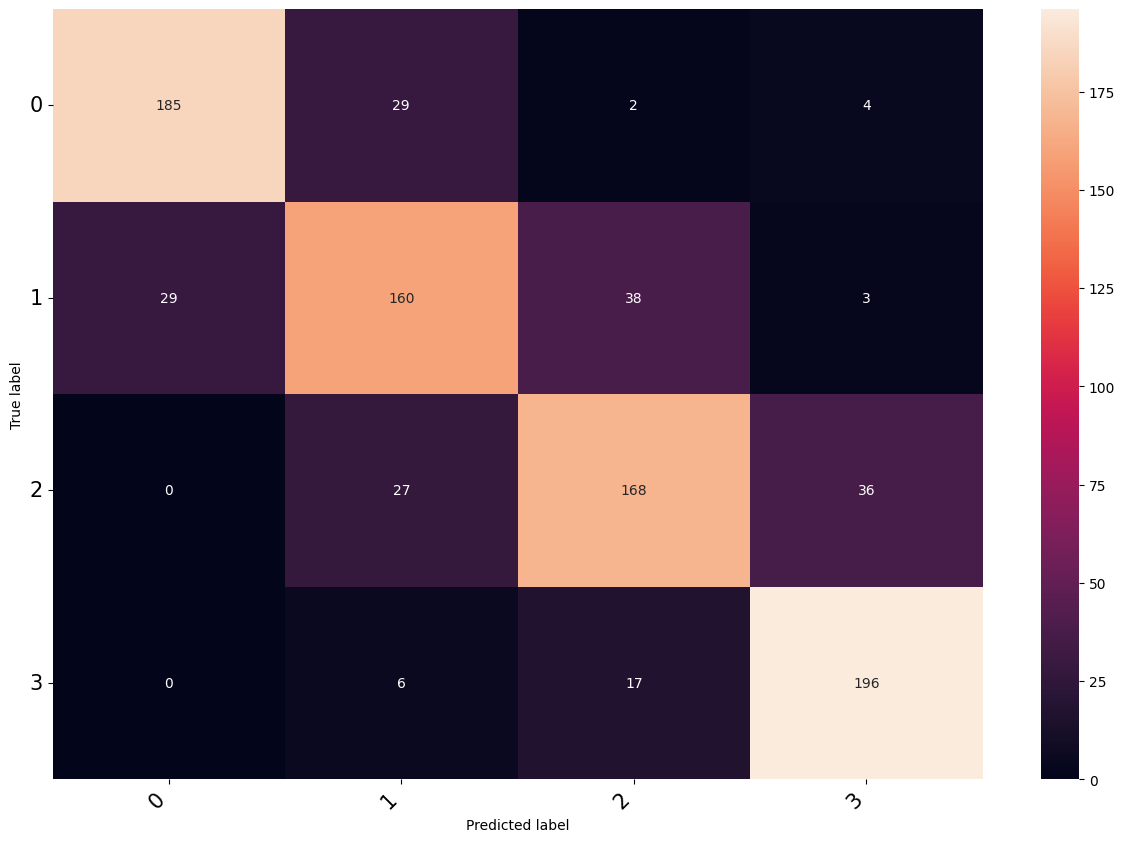

In [51]:
cm.visualize()

In [52]:
cm.class_accuracy

tensor([0.8409, 0.6957, 0.7273, 0.8950])

### GAT

In [53]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [54]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 576/576 [1:25:52<00:00,  8.95s/it]


#### Results

In [55]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 9928/9928 [15:30<00:00, 10.67it/s]


In [56]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3726916623065747,
 'epoch': 31,
 'train_loss': 1.3631123,
 'train_acc': 0.581250011920929,
 'val_acc': 0.5249999761581421,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.52_2023-03-29_06.11.37.857376',
 'train_rmse': 0.9219544457292888,
 'val_rmse': 1.0606601717798212,
 'test_rmse': 1.0126971687308874,
 'train_mae': 0.55,
 'val_mae': 0.6583333333333333,
 'test_mae': 0.6433333333333333,
 'train_mcc': 0.4432677335701185,
 'test_mcc': 0.368188926633393,
 'test_acc': 0.5199999809265137,
 'train_rmse_perc': 0.22590096,
 'val_rmse

In [57]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 4,
 'num_heads': [2, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.44820338320621544,
 'epoch': 36,
 'train_loss': 1.4766945,
 'train_acc': 0.49166667461395264,
 'val_acc': 0.5833333134651184,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.58_2023-03-29_06.30.15.112550',
 'train_rmse': 1.0723805294763609,
 'val_rmse': 0.9874208829065749,
 'test_rmse': 1.1215069227507148,
 'train_mae': 0.7041666666666667,
 'val_mae': 0.5916666666666667,
 'test_mae': 0.7666666666666667,
 'train_mcc': 0.3236706900282636,
 'test_mcc': 0.2696556060481084,
 'test_acc': 0.448888897895813,
 'train_rmse_perc': 0.267

In [58]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.35580006577681955,
 'epoch': 100,
 'train_loss': 1.2623007,
 'train_acc': 0.5958333611488342,
 'val_acc': 0.5083333253860474,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.51_2023-03-29_06.05.06.507043_100',
 'train_rmse': 0.8850612031567836,
 'val_rmse': 1.1937336386313322,
 'test_rmse': 0.99498743710662,
 'train_mae': 0.525,
 'val_mae': 0.7583333333333333,
 'test_mae': 0.6366666666666667,
 'train_mcc': 0.46678000126772906,
 'test_mcc': 0.3698474063879212,
 'test_acc': 0.5188888907432556,
 'train_rmse_perc': 0.21578346,
 '

In [59]:
pretty([all[k]['dict'] for k in sort_idx])